# Introduction

The Online Retail dataset contains over 500,000 transactions from a UK e-commerce store between December 2010 and December 2011. It records details such as invoices,products,quantities,prices,dates and customer IDs.

This project cleans and prepares the data then analyzes key metrics like revenue,average order value and customer retention. Exploratory analysis highlights top products,sales trends and country-level performance. Finally,customer segmentation which provides insights to improve marketing,retention and sales growth.

# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-data/Online Retail.xlsx


# Load Dataset

In [3]:
# Load the dataset into a pandas DataFrame
df = pd.read_excel('/kaggle/input/online-retail-data/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Overview & Cleaning

## Columns description

Invoice Number – a unique identifier for each transaction

Stock Code & Description – product details

Quantity – number of items purchased

Invoice Date – date and time of purchase

Unit Price – price per unit of product

Customer ID – unique identifier for each customer

Country – location of the customer

In [4]:
# Show column names
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
# Check for null values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.shape

(541909, 8)

In [7]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [8]:
# Create a column 'is_cancel' that is True when InvoiceNo starts with 'C' (case-insensitive).
df['is_cancel'] = df['InvoiceNo'].astype(str).str.startswith('C', na=False)
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_cancel
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False


In [9]:
# Separate cancelled rows
cancelled_rows = df[df['is_cancel']].copy()

# Remove rows where Quantity <= 0 or UnitPrice <= 0 (but keep cancelled rows separately).
# We keep cancelled rows in 'cancelled_rows' and filter them out from the main dataframe.
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0) & (~df['is_cancel'])].copy()

In [10]:
# Create df_clean which excludes cancelled rows and rows with missing CustomerID.
df_clean = df[df['CustomerID'].notna()].copy()

In [11]:
# Show shapes of original df, cancelled_rows and df_clean, and print example cancelled rows.
print("Shape of original df:", df.shape)
print("Shape of cancelled_rows:", cancelled_rows.shape)
print("Shape of df_clean:", df_clean.shape)

Shape of original df: (530104, 9)
Shape of cancelled_rows: (9288, 9)
Shape of df_clean: (397884, 9)


# Feature Engineering & KPIs

In [12]:
# Add a column 'revenue' = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean['Revenue'] = df_clean['Quantity'] * df_clean['UnitPrice']

In [13]:
# Create invoice_totals = df_clean.groupby('InvoiceNo')['Revenue'].sum().reset_index(name='invoice_total') and merges invoice_total back into df_clean.
invoice_totals = df_clean.groupby('InvoiceNo')['Revenue'].sum().reset_index(name='invoice_total')
df_clean = pd.merge(df_clean, invoice_totals[['InvoiceNo', 'invoice_total']], on='InvoiceNo', how='left')

In [14]:
# Add columns: order_year, order_month (as YYYY-MM string), order_dayofweek (Mon/Tue...), order_day, order_hour.
df_clean['order_year'] = df_clean['InvoiceDate'].dt.year
df_clean['order_month'] = df_clean['InvoiceDate'].dt.strftime('%Y-%m')
df_clean['order_dayofweek'] = df_clean['InvoiceDate'].dt.day_name().str[:3] # Get abbreviated day name
df_clean['order_day'] = df_clean['InvoiceDate'].dt.day
df_clean['order_hour'] = df_clean['InvoiceDate'].dt.hour # Extract hour from time

In [15]:
# Add 'is_repeat_customer' flag computed later (just add the placeholder column set to False for now).
df_clean['is_repeat_customer'] = False

In [16]:
# total revenue (sum of revenue)
total_revenue = df_clean['Revenue'].sum()
print(f"Total Revenue: ${total_revenue:,.2f}")

# total orders (count of unique InvoiceNo excluding cancelled)
total_orders = df_clean['InvoiceNo'].nunique()
print(f"Total Orders: {total_orders:,}")

# total customers (distinct CustomerID)
total_customers = df_clean['CustomerID'].nunique()
print(f"Total Customers: {total_customers:,}")

# percent_repeat_customers (percent of customers with >1 invoice)
customer_invoice_counts = df_clean.groupby('CustomerID')['InvoiceNo'].nunique()
repeat_customers_count = (customer_invoice_counts > 1).sum()
percent_repeat_customers = (repeat_customers_count / total_customers) * 100 if total_customers > 0 else 0
print(f"Percent Repeat Customers: {percent_repeat_customers:.2f}%")

# revenue_lost_to_cancellations (sum of revenue for cancelled rows)
# Assuming cancelled_rows DataFrame has a 'revenue' column (calculated similarly if not)
if 'Revenue' not in cancelled_rows.columns:
    cancelled_rows['Revenue'] = cancelled_rows['Quantity'] * cancelled_rows['UnitPrice']
revenue_lost_to_cancellations = cancelled_rows['Revenue'].sum()
print(f"Revenue Lost to Cancellations: ${revenue_lost_to_cancellations:,.2f}")

Total Revenue: $8,911,407.90
Total Orders: 18,532
Total Customers: 4,338
Percent Repeat Customers: 65.58%
Revenue Lost to Cancellations: $-896,812.49


# Exploratory Data Analysis

In [17]:
# Data Validation
purple_palette = ['#6A0DAD', '#9B30FF', '#9370DB', '#BA55D3', '#C9A0DC']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=purple_palette)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [18]:
import warnings

This shows that the highest revenue was generated in November 2011 and how monthly revenue fluctuates over time. Peaks suggest seasonal buying behavior, while dips highlight low-demand months.

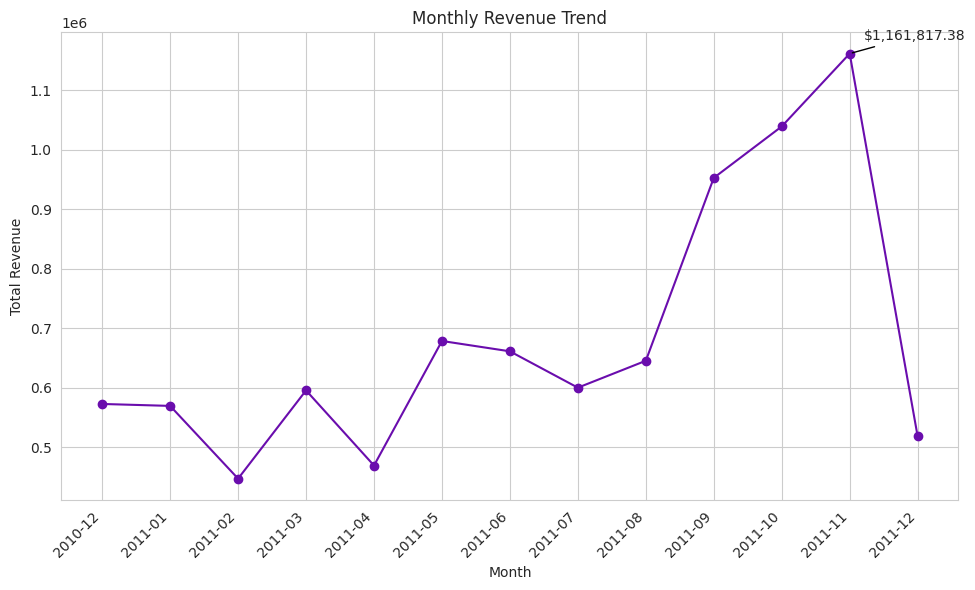

In [19]:
# Monthly revenue
monthly_revenue = df_clean.groupby('order_month')['Revenue'].sum().reset_index()

# A line chart of monthly revenue with markers
fig, ax = plt.subplots()
ax.plot(monthly_revenue['order_month'], monthly_revenue['Revenue'], marker='o', color=purple_palette[0]) # Using the first color from the palette

# The top peak month value
peak_month = monthly_revenue.loc[monthly_revenue['Revenue'].idxmax()]
ax.annotate(f"${peak_month['Revenue']:,.2f}",
            xy=(peak_month['order_month'], peak_month['Revenue']),
            xytext=(10, 10), textcoords='offset points',
            arrowprops=dict(arrowstyle="-", color='black'))
ax.set_xlabel('Month')
ax.set_ylabel('Total Revenue')
ax.set_title('Monthly Revenue Trend')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This visualization highlights the top 10 products generating the highest revenue. It shows which items drive the majority of sales, helping identify key products for promotion, inventory prioritization and cross-selling opportunities.


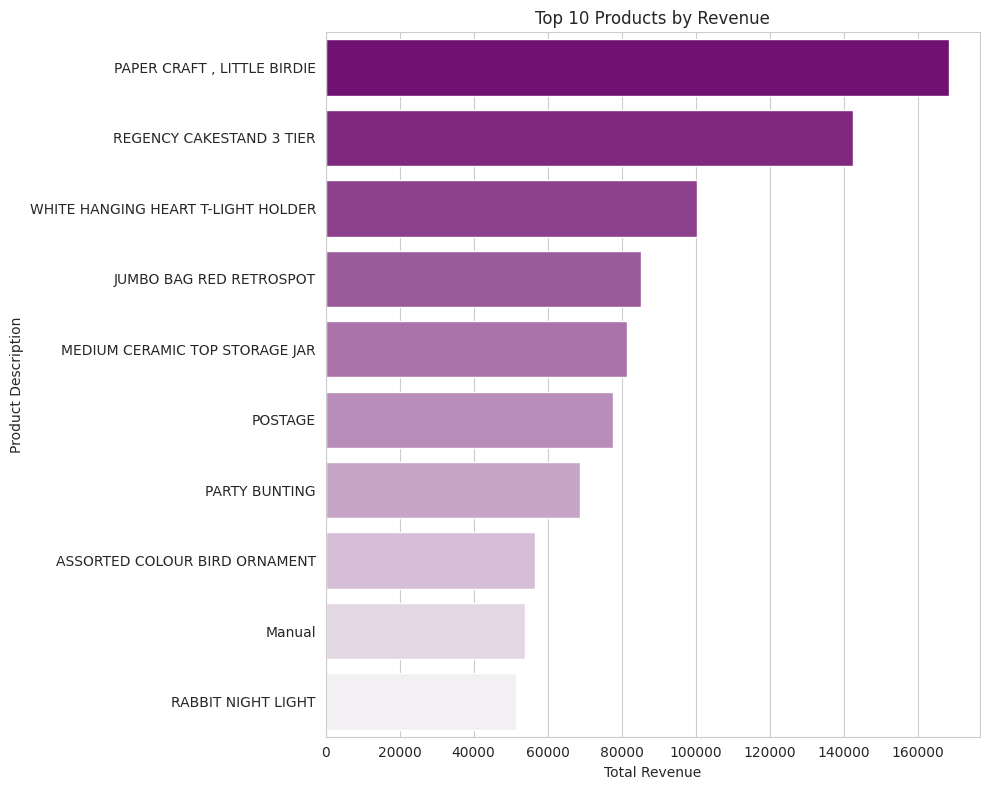

In [20]:
# Group df_clean by Description and sum revenue, get top 10.
top_products = df_clean.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10).reset_index()

# bar chart, product names on y-axis and revenue on x-axis.
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.light_palette("purple", reverse=True, n_colors=len(top_products))
sns.barplot(x='Revenue', y='Description', data=top_products, palette=cmap, ax=ax)
ax.set_xlabel('Total Revenue')
ax.set_ylabel('Product Description')
ax.set_title('Top 10 Products by Revenue')
plt.tight_layout()
plt.show()

it shows revenue distribution across countries outside the UK. While the UK is the main market, some international customers also contribute significantly, indicating opportunities for global market expansion.


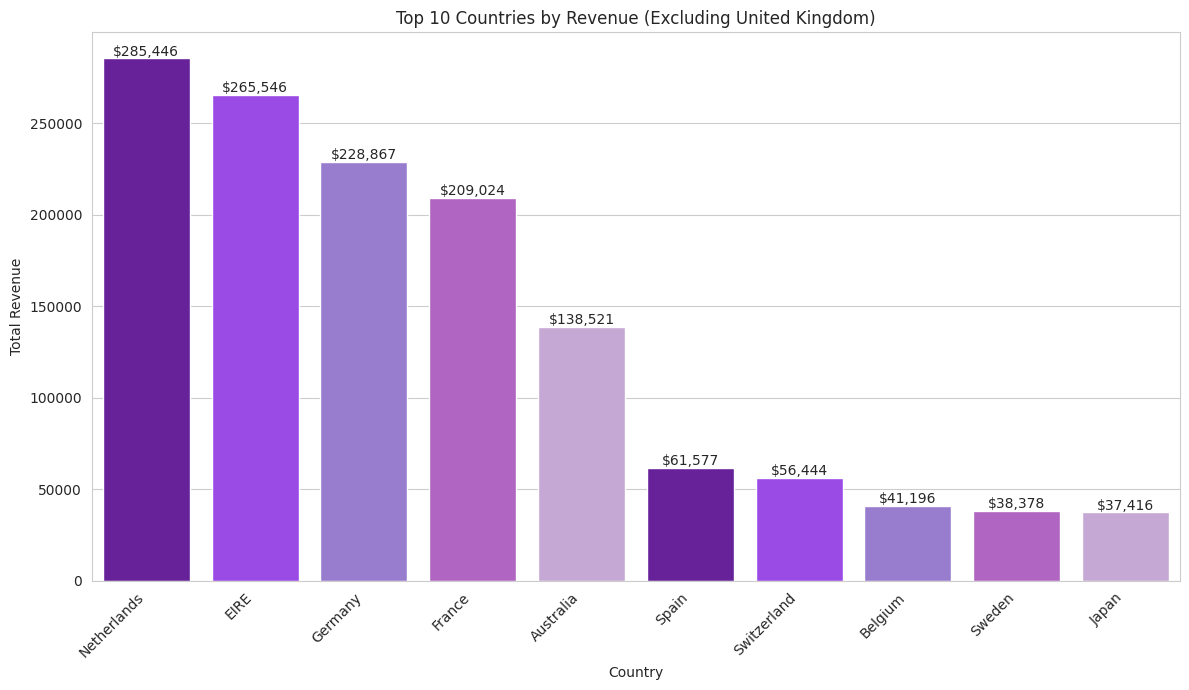

In [21]:
# Revenue by Country, exclude 'United Kingdom', get top 10 countries by revenue.
country_revenue = df_clean[df_clean['Country'] != 'United Kingdom'].groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10).reset_index()

# showing country vs revenue, annotate values.
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x='Country', y='Revenue', data=country_revenue, palette=purple_palette, ax=ax)
for p in ax.patches:
    ax.annotate(f"${p.get_height():,.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
ax.set_xlabel('Country')
ax.set_ylabel('Total Revenue')
ax.set_title('Top 10 Countries by Revenue (Excluding United Kingdom)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This compares one-time buyers against repeat customers. Although many customers purchase only once, repeat buyers contribute more consistent revenue, emphasizing the importance of customer retention strategies.


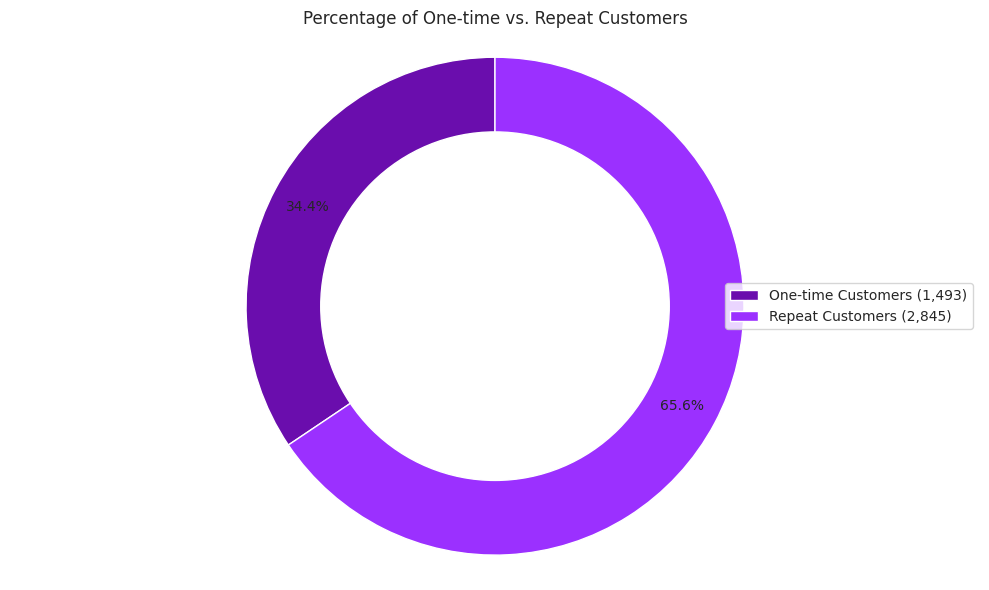

In [22]:
# Group df_clean by CustomerID to count invoices and sum revenue.
customer_summary = df_clean.groupby('CustomerID').agg(
    invoice_count=('InvoiceNo', 'nunique'),
    total_revenue=('Revenue', 'sum')
).reset_index()

# percent of customers with invoice_count == 1 vs >1.
one_time_customers = customer_summary[customer_summary['invoice_count'] == 1].shape[0]
repeat_customers = customer_summary[customer_summary['invoice_count'] > 1].shape[0]
total_customers = customer_summary.shape[0]

percent_one_time = (one_time_customers / total_customers) * 100 if total_customers > 0 else 0
percent_repeat = (repeat_customers / total_customers) * 100 if total_customers > 0 else 0

# Prepare data for the donut chart
labels = [f'One-time Customers ({one_time_customers:,})', f'Repeat Customers ({repeat_customers:,})']
sizes = [percent_one_time, percent_repeat]
colors = [purple_palette[0], purple_palette[1]] # Use two colors from the purple palette
# Create a purple donut chart showing % one-time vs repeat customers, show absolute counts in legend
fig, ax = plt.subplots()
ax.pie(sizes, labels=None, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a circle in the center to create the donut effect
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')
plt.title('Percentage of One-time vs. Repeat Customers')
ax.legend(labels, loc="center right", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

The distribution plot shows how order values are spread across customers. Most invoices are low in value, but a few high-value orders create a long tail. The boxplot helps identify outliers in spending behavior.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


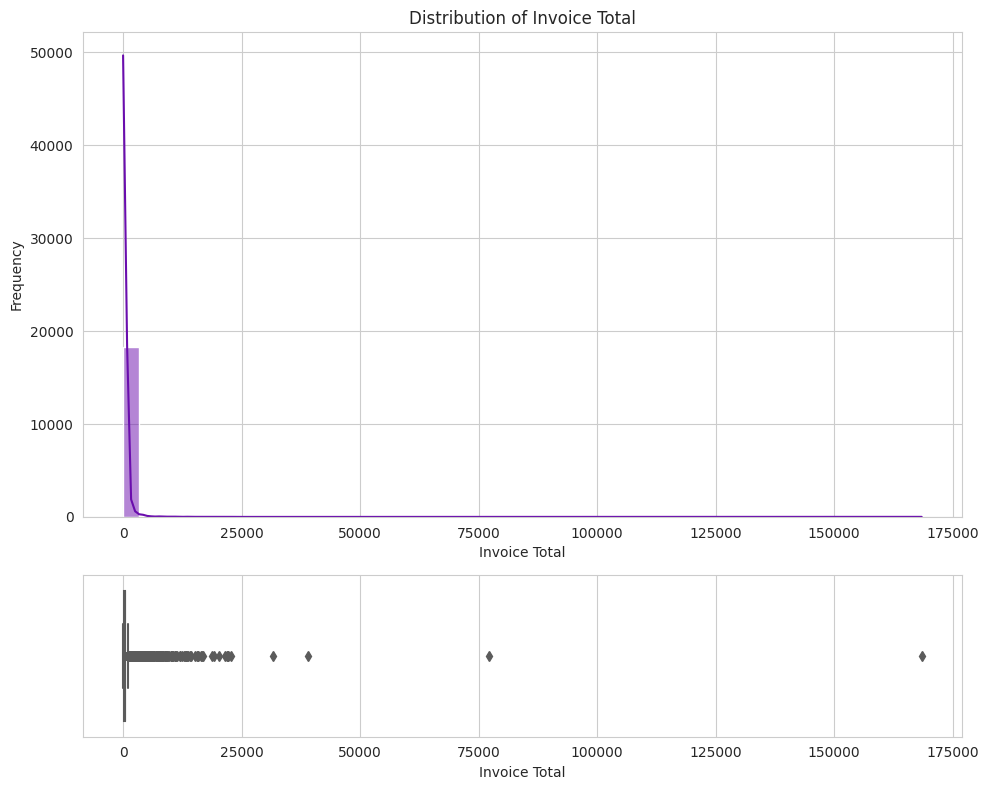

In [23]:
# Plot a histogram of invoice_total with purple bins, and a separate boxplot below.
fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]}) # Create subplots for histogram and boxplot

# Histogram
sns.histplot(data=invoice_totals, x='invoice_total', bins=50, ax=axes[0], color=purple_palette[0], kde=True)
axes[0].set_title('Distribution of Invoice Total')
axes[0].set_xlabel('Invoice Total')
axes[0].set_ylabel('Frequency')
# axes[0].set_xscale('log') # Uncomment to use log scale on x-axis

# Boxplot
sns.boxplot(data=invoice_totals, x='invoice_total', ax=axes[1], color=purple_palette[1])
axes[1].set_xlabel('Invoice Total')
axes[1].set_yticks([]) # Remove y-axis ticks for the boxplot
plt.tight_layout()
plt.show()

This visualization identifies products with the highest revenue lost to cancellations. Monitoring these items helps the business reduce errors, improve product quality and minimize refund-related revenue loss.


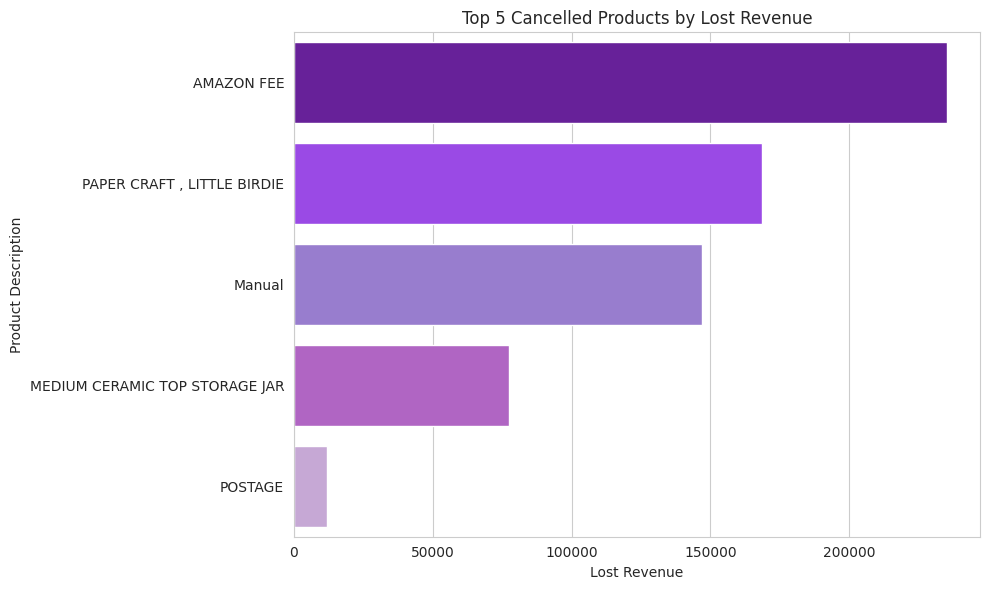

In [24]:
# From the cancelled rows (is_cancel True), lost revenue per Description (sum of revenue absolute value).
if 'Revenue' not in cancelled_rows.columns:
    cancelled_rows['Revenue'] = cancelled_rows['Quantity'] * cancelled_rows['unitprice']

cancelled_revenue_by_product = cancelled_rows.groupby('Description')['Revenue'].sum().abs().sort_values(ascending=False).head(5).reset_index()

# Show top 5 cancelled products by lost revenue bar chart
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Revenue', y='Description', data=cancelled_revenue_by_product, palette=purple_palette, ax=ax)
ax.set_xlabel('Lost Revenue')
ax.set_ylabel('Product Description')
ax.set_title('Top 5 Cancelled Products by Lost Revenue')
plt.tight_layout()
plt.show()

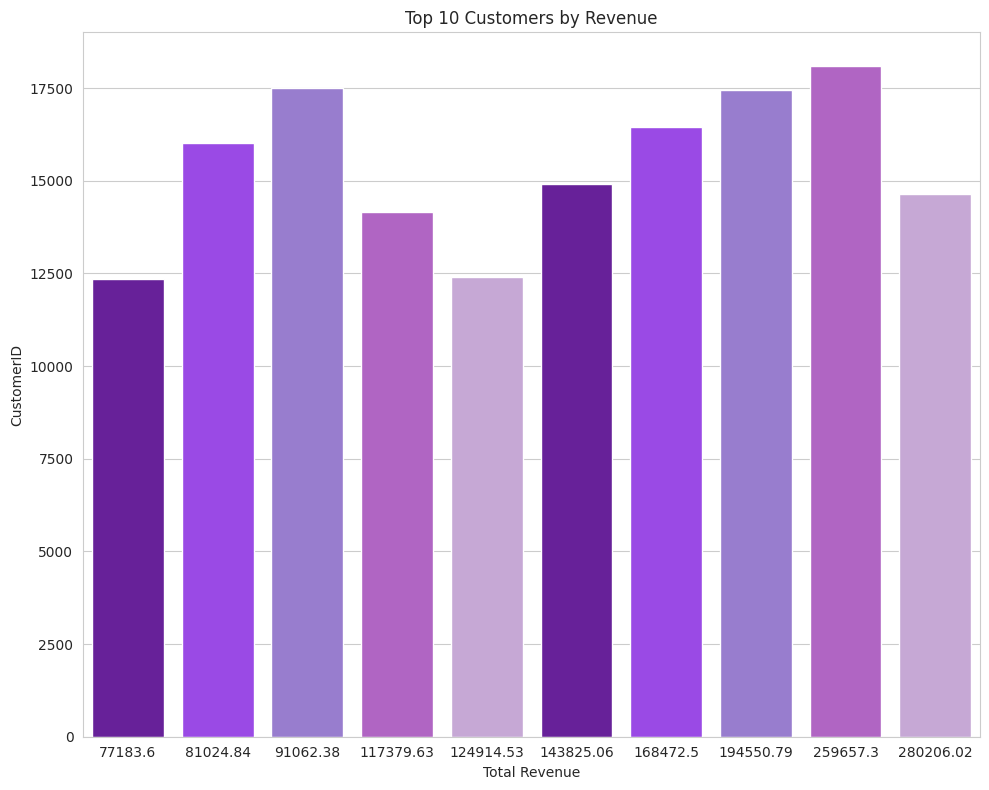

In [25]:
# Top 10 total revenue per CustomerID.
top_customers = df_clean.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False).head(10).reset_index()
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='Revenue', y='CustomerID', data=top_customers, palette=purple_palette, ax=ax)
ax.set_xlabel('Total Revenue')
ax.set_ylabel('CustomerID')
ax.set_title('Top 10 Customers by Revenue')
plt.tight_layout()
plt.show()

# Conclusion  

This analysis revealed key patterns in sales and customer behavior. Revenue is driven by a small group of products and loyal repeat customers, while many buyers purchase only once. Geographic analysis showed the UK as the primary market, with notable international contributions.  

By applying clustering, we segmented customers into meaningful groups, enabling targeted marketing strategies and improved customer retention. These insights highlight the value of data-driven decision making in growing and sustaining online retail businesses.  
